In [8]:
import rioxarray as rxr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import subprocess
import os
import utm
import pandas as pd
import xarray as xr
import rasterio as rio
from scipy.interpolate import griddata
from rasterio.enums import Resampling
from pyproj import Transformer
from xrspatial import hillshade
# import sys
# sys.path.insert(0,"../py/")
# import victor

- import and plot geotiff
- import shapefile/geometry
- try to print shape onto geometry

In [9]:
vent_latitude = 63.890688
vent_longitude = -22.269106

dem = "../dem/Iceland_20mx20m_cropped.tif"

x = rio.open(dem)
bounds = x.bounds
crs = x.crs

transformer = Transformer.from_crs("EPSG:4326",crs)
converted = transformer.transform(vent_latitude,vent_longitude)
vent_easting = converted[0]
vent_northing = converted[1]

volume = 1e8

name = "fagradalsfjall"

# For IMEX, we assign a reasonable yet arbitrary time for the flow to run (in seconds)
# Please change it at your leisure
run_time = 1000

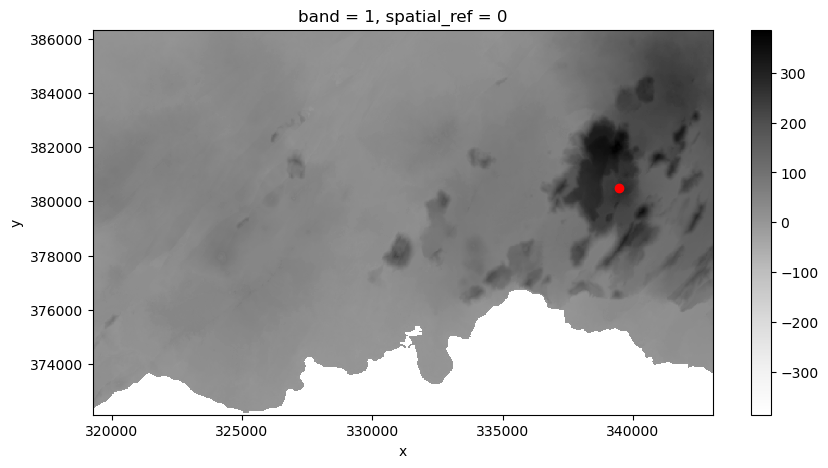

In [11]:
coordinates = np.array([vent_easting, vent_northing])
raster = rxr.open_rasterio(dem, masked=True).squeeze()
f, ax = plt.subplots(figsize=(10, 5))
raster.plot(cmap="Greys",
                 ax=ax)
plt.scatter(vent_easting, vent_northing,c='red')

In [12]:
raster = rxr.open_rasterio(dem)
raster = raster.sel({"band": 1})
xll, yll = int(raster.x.min()), int(raster.y.min())
coordinates = np.array([int(vent_easting),int(vent_northing)])
r = rio.open(dem)
res = r.res

output_num = str(int(run_time/100))
out = output_num.zfill(4)

filename, file_extension = os.path.splitext(dem)
file_name = os.path.basename(dem)
file_name = os.path.splitext(file_name)[0]
type_flag = 0 #0 is ascii, 1 is tiff
if file_extension in [".geotiff", ".tiff", ".tif"]:
    type_flag = 1
    asc_name = "".join((file_name, ".asc"))
    raster.rio.to_raster(asc_name)
    os.remove("".join((asc_name, ".aux.xml")))
    os.remove("".join((file_name, ".prj")))
    cell_size = open(f"""{asc_name}""","r+")
    info = cell_size.readlines()
    uniform = info[4].split()
    if uniform[0] == 'dx':
        info[4] = f"""cellsize     {int(float(uniform[1]))}\n"""
        info[5] = ""
        cell_size.seek(0)
        cell_size.writelines(info)
        cell_size.truncate()
        cell_size.close()
elif file_extension in [".asc", ".ascii"]:
    type_flag = 0
    tiff_name = "".join((file_name, ".tiff"))
    raster.rio.to_raster(tiff_name)